<a href="https://colab.research.google.com/github/chemicoPy/Flight_Prediction/blob/main/Flight_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import seaborn as sns; sns.set()
#%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import io
import math
import pickle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving flightdata.csv to flightdata.csv




# Data check

In [3]:
  
df = pd.read_csv(io.BytesIO(uploaded['flightdata.csv']))
df.head()
print("")
print("Shape of data: ", df.shape)
print("")
df.isnull().values.any()
df.isnull().sum()



Shape of data:  (11231, 26)



YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

In [4]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,14747,SEA,1905,1907.0,2.0,0.0,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,13487,MSP,1345,1344.0,-1.0,0.0,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,14747,SEA,940,942.0,2.0,0.0,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,13487,MSP,819,820.0,1.0,0.0,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,11433,DTW,2300,2256.0,-4.0,0.0,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [5]:
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST","CRS_DEP_TIME", "ARR_DEL15"]]
df.isnull().sum()
df[df.isnull().values.any(axis=1)].head()
df = df.fillna({'ARR_DEL15': 1})
df.iloc[177:185]
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,1905,0.0
1,1,1,5,DTW,MSP,1345,0.0
2,1,1,5,ATL,SEA,940,0.0
3,1,1,5,SEA,MSP,819,0.0
4,1,1,5,SEA,DTW,2300,0.0


In [6]:
for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0,0,0,0,1,0,1,0,0,0


In [7]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15',axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)

train_x.shape

(8984, 14)

In [21]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)
model_name = 'flight_prediction.sav'
pickle.dump(model, open(model_name, 'wb'))
predicted = model.predict(test_x)
print(model.score(test_x, test_y))
("Percentage score: ", (model.score(test_x, test_y)*100)) # in percentage


0.8642634623943035


('Percentage score: ', 86.42634623943036)

In [9]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)
roc_auc_score(test_y, probabilities[:, 1])


0.7014819895830565

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

from sklearn.metrics import precision_score
train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)


1.0

In [14]:

from sklearn.metrics import recall_score
recall_score(train_y, train_predictions)

0.9992012779552716

Text(0, 0.5, 'True Positive Rate')

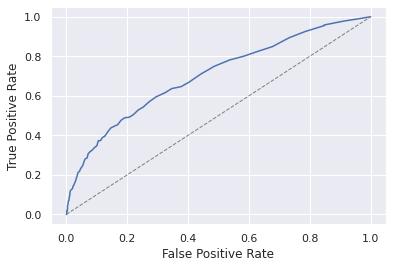

In [15]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [16]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime
    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time,'%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()
    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0}]
    return model.predict_proba(pd.DataFrame(input))[0][0]


# Testing model

In [17]:
predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')
predict_delay('2/10/2018 10:00:00', 'ATL', 'SEA')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- DAY
Feature names seen at fit time, yet now missing:
- DAY_OF_MONTH

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- DAY
Feature names seen at fit time, yet now missing:
- DAY_OF_MONTH

  warnings.warn(message, FutureWarning)


0.99

In [ ]:
""" Probabilistic scores of predicted arrival time/date """

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- DAY
Feature names seen at fit time, yet now missing:
- DAY_OF_MONTH

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- DAY
Feature names seen at fit time, yet now missing:
- DAY_OF_MONTH

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- DAY
Feature names seen at fit time, yet now missing:
- DAY_OF_MONTH

  warnings.warn(message, FutureWarning)
/

(0.0, 1.0)

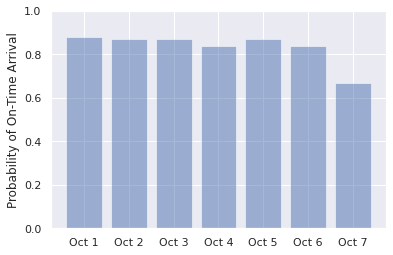

In [18]:
labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))



alabels = np.arange(len(labels))
plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))
